# data analysis ahead of modelling


## flag used in this script, checking them before running
- Test = "T1"/"T2"
- T3 = True/False
- woe_run -> True/False. 'True' will not trigger Test and T3

# without woe transmation, feature processing after T1 gave best performance
# features after woe gave similar performance

In [53]:
import pandas as pd
import xgboost as xgb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve, average_precision_score

In [54]:
def remove_skewed_columns(df):
# this function was used to remove the column that has only one value
    for column in df:
        if len(df[column].unique()) == 1:
            df.drop(columns=column, inplace=True)
    return df

In [55]:
woe_run = True

In [56]:
# load the file
if woe_run:
    df = pd.read_csv("../woe_transformation/dataset_test_woed.csv", index_col=["ID"])
    df.drop( "Unnamed: 0", axis=1, inplace=True)
    df.rename(columns={"target": "default payment next month"}, inplace=True)
else:
    df = pd.read_csv("../credit_risk_data.csv", skiprows=1, index_col="ID")

df = remove_skewed_columns(df)
df


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,0.692865,-0.079777,0.091416,0.076822,0.041466,2.065423,1.473415,-0.430029,-0.407307,-0.147246,...,0.061971,0.111703,0.056681,0.677342,0.012750,0.521223,0.463320,0.382161,0.361833,1
2,0.103760,-0.079777,0.091416,-0.072942,0.041466,-0.342752,1.473415,-0.295297,-0.235542,-0.200910,...,-0.341374,-0.383466,-0.434588,0.677342,0.053114,0.098836,0.046470,0.382161,0.007203,1
3,0.103760,-0.079777,0.091416,-0.072942,-0.161146,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,-0.023247,0.119063,0.121763,0.120994,0.174191,0.098836,0.046470,0.026641,-0.370422,0
4,0.273008,-0.079777,0.091416,0.076822,0.052545,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,0.178366,0.202243,0.226296,0.043100,-0.183815,-0.083967,0.046470,0.026641,-0.094260,0
5,0.273008,0.115154,0.091416,0.076822,0.052545,-0.342752,-0.406083,-0.430029,-0.235542,-0.200910,...,0.243437,0.247299,0.301036,0.043100,-1.125815,-0.541741,-0.449736,0.181627,0.236430,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,-0.302390,0.115154,0.168463,0.076822,0.052545,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,-0.006246,0.202243,0.121763,-0.491163,-1.125815,-0.544802,-0.316342,-0.452800,-0.094260,0
29997,-0.302390,0.115154,0.168463,-0.072942,0.052545,-0.342752,-0.402003,-0.430029,-0.407307,-0.200910,...,-0.030937,-0.383466,0.056681,0.043100,-0.126413,-0.290394,-0.086809,0.382161,0.361833,0
29998,0.651911,0.115154,0.091416,-0.072942,0.052545,2.199295,1.640054,1.319915,-0.407307,-0.200910,...,0.243437,0.101398,0.301036,0.677342,0.562642,-0.886388,-0.493851,0.017868,-0.253901,1


## imbalanced data processing
- calcuate 'scale_pos_weight' (label 0/1), use the weight in the XGBClassifier

In [57]:
scale_pos_weight = sum(abs(df["default payment next month"] - 1))/sum(df["default payment next month"])

In [62]:
df["EDUCATION"].unique()
df["SEX"].unique()
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,0.692865,-0.079777,0.091416,0.076822,0.041466,2.065423,1.473415,-0.430029,-0.407307,-0.147246,...,0.061971,0.111703,0.056681,0.677342,0.012750,0.521223,0.463320,0.382161,0.361833,1
2,0.103760,-0.079777,0.091416,-0.072942,0.041466,-0.342752,1.473415,-0.295297,-0.235542,-0.200910,...,-0.341374,-0.383466,-0.434588,0.677342,0.053114,0.098836,0.046470,0.382161,0.007203,1
3,0.103760,-0.079777,0.091416,-0.072942,-0.161146,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,-0.023247,0.119063,0.121763,0.120994,0.174191,0.098836,0.046470,0.026641,-0.370422,0
4,0.273008,-0.079777,0.091416,0.076822,0.052545,-0.659061,-0.406083,-0.295297,-0.235542,-0.200910,...,0.178366,0.202243,0.226296,0.043100,-0.183815,-0.083967,0.046470,0.026641,-0.094260,0
5,0.273008,0.115154,0.091416,0.076822,0.052545,-0.342752,-0.406083,-0.430029,-0.235542,-0.200910,...,0.243437,0.247299,0.301036,0.043100,-1.125815,-0.541741,-0.449736,0.181627,0.236430,0


# zeros data processing

## T1:  defualt the unreasonable data to missing data and labeled 0
## T2:  defualt the unreasonable data to data value that appears most frequently
## T3:  pay status: change all negative to 0 and positive to 1

In [59]:
Test = "T2"
T3 = False

In [60]:
if not woe_run:
# defualt the unreasonable data to missing data and labeled 0
    if Test == "T1":
        df["EDUCATION"][df["EDUCATION"] == 5] = 0
        df["EDUCATION"][df["EDUCATION"] == 6] = 0
    elif Test == "T2":
        count = 0
        for i in range(5):
            if sum(df["EDUCATION"]==i) > count:
                count = sum(df["EDUCATION"]==i)
                max = i
        df["EDUCATION"][df["EDUCATION"] == 5] = max
        df["EDUCATION"][df["EDUCATION"] == 6] = max

    if T3:
        for i in [0, 2, 3, 4, 5, 6]:
            df["PAY_" + str(i)][df["PAY_" + str(i)] < 0] = 0
            df["PAY_" + str(i)][df["PAY_" + str(i)] > 0] = 1
    # convert "SEX", "EDUCATION", "MARRIAGE" to category data using one-hot encode
    df_encoded = pd.get_dummies(df,columns=["SEX", "EDUCATION", "MARRIAGE"])
    sum(df_encoded["EDUCATION_2"])
else:
    df_encoded = df
# len(df["PAY_" + str(0)][df["PAY_" + str(i)] < 0])
    

## feature selection
- compare the model behaviours with different features using AUC_pr (due to imbalanced data with minority in positives, recall value reflects the misclassification of defualt on the loan, increase the loan risk) under the same boost rounds. One feature was removed in each iteration and the feature will be removed if AUC and recall value is enhanced.
- set 40 for fixed boost rounds for now? may need to adjust
## T1 (best) -> features saved in selected_feature_T1.p
* auc under pr curve when using all features is 0.53165
* no feature needed to removed
## T2
* auc under pr curve when using all features is 0.53136
* no feature needed to removed
## T1 + T3
* auc under pr curve when using all features is 0.51245
* no feature needed to removed

In [61]:
# fit the model with all features
trial_xgb = xgb.XGBClassifier(n_estimators= 40,objective="binary:logistic", verbosity = 0, scale_pos_weight = scale_pos_weight, use_label_encoder=False, random_state = 10)
# seperate X and y
X = df_encoded.drop("default payment next month", axis=1).copy()
y = df_encoded["default payment next month"].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 8, stratify = y)
trial_xgb.fit(X_train, y_train, verbose=True , early_stopping_rounds = 10, eval_metric="aucpr",eval_set=[(X_test,y_test)])
# pr value
trial_auc = np.array(trial_xgb.evals_result()['validation_0']['aucpr']).max()
# plot_confusion_matrix(trial_xgb, X_test,y_test, display_labels=["Default not on the loan", "Default on the loan"]) 
# trial_xgb.evals_result()


[0]	validation_0-aucpr:0.52023
[1]	validation_0-aucpr:0.52332
[2]	validation_0-aucpr:0.52897
[3]	validation_0-aucpr:0.52842
[4]	validation_0-aucpr:0.52497
[5]	validation_0-aucpr:0.52902
[6]	validation_0-aucpr:0.53002
[7]	validation_0-aucpr:0.52957
[8]	validation_0-aucpr:0.52833
[9]	validation_0-aucpr:0.52698
[10]	validation_0-aucpr:0.52466
[11]	validation_0-aucpr:0.52752
[12]	validation_0-aucpr:0.53019
[13]	validation_0-aucpr:0.52983
[14]	validation_0-aucpr:0.52712
[15]	validation_0-aucpr:0.52619
[16]	validation_0-aucpr:0.52569
[17]	validation_0-aucpr:0.52577
[18]	validation_0-aucpr:0.52513
[19]	validation_0-aucpr:0.52337
[20]	validation_0-aucpr:0.52306
[21]	validation_0-aucpr:0.52085


In [63]:
# calculate recall value
# y_pred = trial_xgb.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# recall_val = cm[1,1] / (cm[1,0]+cm[1,1])
# recall_val

In [64]:
# use auc under pr to calculate the feature, 
X_copy = X.copy()
removed_cols = []
for col in X:
    X_train, X_test, y_train, y_test = train_test_split(X_copy.drop(col, axis=1).copy(),y, test_size=0.2, random_state = 8, stratify = y)
    trial_xgb.fit(X_train, y_train, verbose = False, eval_metric="aucpr",eval_set=[(X_test,y_test)])
    # auc under pr
    trial_auc2 = np.array(trial_xgb.evals_result()['validation_0']['aucpr']).max()
    y_pred = trial_xgb.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    recall_val2 = cm[1,1] / (cm[1,0]+cm[1,1])
    if abs(trial_auc2 - trial_auc) > 0.05:
        removed_cols.append({"col": col, "aucpr": trial_auc2})
        X_copy.drop(col, axis=1, inplace=True)
removed_cols

[]

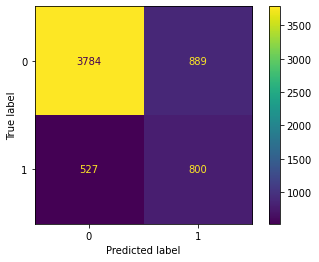

In [65]:
plot_confusion_matrix(trial_xgb, X_test, y_test)

## save the processed data

In [66]:

pickle.dump( {"X": X_copy, "y": y, "auc_pr": trial_xgb.evals_result()['validation_0']['aucpr']}, open( "./woe_data_model/selected_feature_T2.p", "wb" ) )


In [48]:
X_copy.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,1,0,0,1,0,0,0,1,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,1,0,0,1,0,0,0,0,1,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,1,0,0,1,0,0,0,0,1,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1,0,0,1,0,0,0,1,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,0,0,0,1,0,0,0,1,0,0


# plot data

In [128]:
T1_features = pickle.load(open( "selected_feature_T1.p", "rb" ))
T1_aucpr = T1_features["auc_pr"]

In [129]:
T2_features = pickle.load(open( "selected_feature_T2.p", "rb" ))
T2_aucpr = T2_features["auc_pr"]

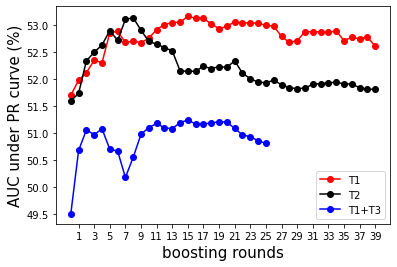

In [136]:
f1 = plt.figure()
t1t3, = plt.plot([x for x in range(len(trial_xgb.evals_result()['validation_0']['aucpr']))], 
         np.array(trial_xgb.evals_result()['validation_0']['aucpr'])*100, "bo-")

t1, = plt.plot([x for x in range(len(T1_aucpr))], 
         np.array(T1_aucpr)*100, "ro-")
t2, = plt.plot([x for x in range(len(T2_aucpr))], 
         np.array(T2_aucpr)*100, "ko-")

plt.xticks([x for x in range(len(T1_aucpr)) if x % 2 != 0], [x for x in range(len(T1_aucpr)) if x % 2 != 0])
plt.xlabel("boosting rounds", fontsize=15)
plt.ylabel("AUC under PR curve (%)", fontsize=15)
plt.legend([t1, t2, t1t3], ["T1", "T2", "T1+T3"])
f1.savefig('test.jpg', format='jpg', dpi=1200)